In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Projet optimisation : algorithme SDCA

Plan que je propose : 

On va se concentrer sur l'algorithme SVM avec régularisation LASSO. Afin de pouvoir fixer de manière optimale les pas de descentes, nous allons utiliser une version smooth de la hinge loss (Rennie and Srebro's ou Huber loss, je sais pas trop encore...) 

(insérer equation de la fonction de perte ici)

(détailler le calcul du gradient)

(détailler le calcul du prox)


Etant donné que nous sommes exceptionnellement un groupe constitué de trois personnes, nous vous proposons le sujet 1 enrichi avec le sujet 3. Concrètement, nous allons implémenter 4 méthodes d'optimisations, puis les comparer sur la base de données ... (à choisir) :
- Batch Proximal Gradient Descent (avec accéleration Nesterov, aka FISTA)
- SDCA (avec eventuellement quelques optimisations présentées dans l'article)
- SVRG
- SAGA

*[Partie 1 : Batch Proximal Gradient Descent](#section1)

*[Partie 2 : SDCA](#section2)

*[Partie 3 : SVRG](#section3)

*[Partie 4 : SAGA](#section4)

*[Partie 5 : Comparaison](#section1)

# Définition des données

On commence par définir les données de test (il faudra plus tard mettre les vraies données)

In [2]:
np.random.seed(0)

def binarize(x):
    return np.sign(x)

n_samples, n_features = 1000, 2
X = np.random.randn(n_samples, n_features)
w = np.random.randn(n_features)
b = binarize(X.dot(w) + 0 * np.random.randn(n_samples))

On définit aussi les fonctions de couts et gradient

In [3]:
def f(theta, lam):
    cost = 1-np.multiply(b,X.dot(theta))
    cost[cost <= 0] = 0
    return np.mean(cost) + lam * np.linalg.norm(theta, ord=1)


def partial_grad(theta, i):
    if b[i] * X[i].dot(theta) < 1:
        return -b[i] * X[i]
    return 0 * X[i] 


def grad(theta):
    gradient = -np.multiply(b, X.T)
    
    gradient[:,np.multiply(b, X.dot(theta)) >= 1] = 0 * gradient[:,np.multiply(b, X.dot(theta)) >= 1]
    
    return np.mean(gradient, axis=1)

et les différentes constantes :
- pénalisation : lambda = 0.1
- pas de descente : eta = 0.1
- nombre d'itération : T = 200

In [4]:
lam = 0.1
eta = 0.1
T = 200

<a id='section1'></a>
Batch Proximal Gradient Descent

In [5]:
def PGD(T, lam, eta):
    # pas de la descente
    # Lipschitz constant
    #L = np.linalg.norm(X.T.dot(X))
    #eta = 1. / L
    
    
    # initialisation
    theta = np.zeros(n_features)
    
    # historique de la fonction de perte
    cost_history = np.empty(shape=[T])
    
    for t in range(0,T):
        cost_history[t] = f(theta, lam)
        
        # compute gradient
        gt = grad(theta)
        
        # compute prox
        theta = theta - eta * gt - eta * lam * np.sign(theta)
        
        
               
    return theta, cost_history

In [6]:
%timeit PGD(T=T,lam=lam,eta=eta)

10 loops, best of 3: 41.3 ms per loop


In [7]:
theta, cost_history_PGD = PGD(T=T,lam=lam,eta=eta)

In [8]:
print(theta)
print(w)

[-1.04200987 -1.20004418]
[-1.53292105 -1.71197016]


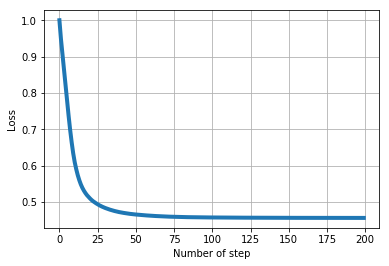

In [9]:
plt.plot(cost_history_PGD, lw=4)
plt.grid()
#plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Number of step')
plt.show()

On passe à l'accélération Nesterov

In [10]:
def FISTA(T, lam, eta):
    # pas de la descente
    # Lipschitz constant
    #L = np.linalg.norm(X.T.dot(X))
    #eta = 1. / L
    #eta = 0.1
    st_moins2 = 1.
    st_moins1 = 1.
    st = 1.
    
    # initialisation
    theta_moins1 = np.zeros(n_features)
    theta = np.zeros(n_features)
    theta_nesterov = np.zeros(n_features)
    
    # historique de la fonction de perte
    cost_history = np.empty(shape=[T])
    
    for t in range(0,T):
        cost_history[t] = f(theta, lam)
        
        # compute gradient
        gt = grad(theta_nesterov)
        
        # compute st
        st_moins2 = st_moins1
        st_moins1 = st
        st = (1 + np.sqrt(1 + 4 * st**2)) / 2 
        
        # compute prox
        theta_moins1 = theta
        theta = theta_nesterov - eta * gt - eta * lam * np.sign(theta_nesterov)
        
        # compute nestorov acceleration
        theta_nesterov = theta + (st_moins2 / st_moins1) * (theta - theta_moins1)
        
        
               
    return theta_nesterov, cost_history

In [11]:
%timeit FISTA(T=T,lam=lam,eta=eta)

10 loops, best of 3: 46.9 ms per loop


In [12]:
theta, cost_history_FISTA = FISTA(T=T,lam=lam,eta=eta)

In [13]:
print(theta)
print(w)

[-1.03056107 -1.19506636]
[-1.53292105 -1.71197016]


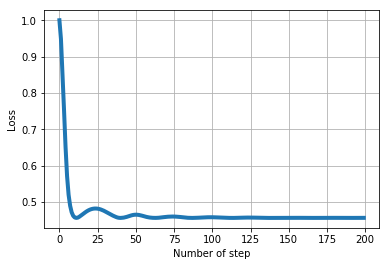

In [14]:
plt.plot(cost_history_FISTA, lw=4)
plt.grid()
#plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Number of step')
plt.show()

<a id='section2'></a>
SDCA

Nous allons d'abord implémenter la version la plus classique de l'algorithme, avant de mettre en oeuvre les variantes et améliorations proposées dans http://www.jmlr.org/papers/volume14/shalev-shwartz13a/shalev-shwartz13a.pdf

On définit les fonctions de coût (primal et dual) qui permettront de monitorer l'avancée de l'algorithme. (Remarque : la fonction P est identique que la fonction f définie plus haut, mais on décide de la redéfinir ici pour coller aux notations de l'article)

In [15]:
#step_size = 1.0 / (3 * np.max((X * X).sum(1)))      #ici on travaille toujours avec un step_size constant


def P(theta, lam):
    cost = 1-np.multiply(b,X.dot(theta))
    cost[cost <= 0] = 0
    return np.mean(cost) + lam * np.linalg.norm(theta, ord=1)

def D(alpha, lam):
    cost = np.multiply(b,X.dot(theta))
    cost[cost > 0] = np.nan
    cost[cost < -1] = np.nan
    return cost                    

### SDCA classique

In [16]:
def SDCA(T, lam, eta):
    alpha = np.zeros(n_samples)
    w = (1/(lam*n_samples))*np.dot(X.T,alpha)
    
    grad_history = np.empty(shape=[T])
    cost_history = np.empty(shape=[T])
    
    for t in range(0,T):
        cost_history[t] = P(w, lam)
        
        # .. pick random sample ..
        idx = np.random.randint(0, n_samples)
        
        # on calcule les constantes A et B (utiles pour la résolution du delta alpha i)
        A = (1/(lam*n_samples)) * np.linalg.norm(X[idx])**2
        B = X[idx].T.dot(w)    
        
        y_i = b[idx]
        delta_alpha_i_tilde = (y_i-B)/A        
        delta_alpha_i = y_i * np.clip(y_i*(delta_alpha_i_tilde + alpha[idx]), a_min=0, a_max=1) - alpha[idx]
        
        alpha[idx] = alpha[idx] + delta_alpha_i
    
        w = (1/(lam*n_samples))*np.dot(X.T,alpha)
        

        
        
    return w, cost_history
        

In [17]:
%timeit SDCA(T=T,lam=lam,eta=eta)

The slowest run took 4.96 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 3: 15 ms per loop


In [18]:
theta, cost_history_SDCA = SDCA(T=T,lam=lam,eta=eta)

In [19]:
print(theta)
print(w)

[-0.60075511 -0.78416373]
[-1.53292105 -1.71197016]


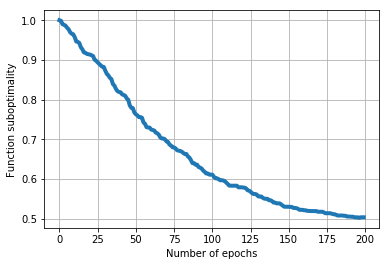

In [20]:
plt.plot(cost_history_SDCA, lw=4)
plt.grid()
#plt.yscale('log')
plt.ylabel('Function suboptimality')
plt.xlabel('Number of epochs')
plt.show()

## SCDA avec SGD initilisation

...

<a id='section3'></a>
SVRG

In [21]:
def SVRG(T, m, lam, eta):
    # initialisation
    theta_hat = np.zeros(n_features)
    
    # historique de la fonction de perte
    cost_history = np.empty(shape=[T])
    
    for t in range(0,T): 
        cost_history[t] = f(theta_hat, lam)
        
        # vrai gradient
        g_hat = grad(theta_hat)
    
        theta = np.zeros([m+1, n_features])
        theta[0,:] = theta_hat
        for k in range(0,m):
            # random sample an indice
            idx = np.random.randint(0, n_samples) 

            # compute variance reduced gradient
            g = partial_grad(theta[k], idx) - partial_grad(theta_hat, idx) + g_hat

            # compute prox
            theta[k+1] = theta[k] - eta * g - eta * lam * np.sign(theta[k])
        
        # on retire la première ligne
        theta = theta[1:]
        
        theta_hat = np.mean(theta, axis=0)
        
        
               
    return theta_hat, cost_history

In [22]:
%timeit SVRG(T=T,m=10,lam=lam,eta=eta)

10 loops, best of 3: 96.7 ms per loop


In [23]:
theta, cost_history_SVRG = SVRG(T=T, m=10, lam=lam, eta=eta)

In [24]:
print(theta)
print(w)

[-1.06441504 -1.22553445]
[-1.53292105 -1.71197016]


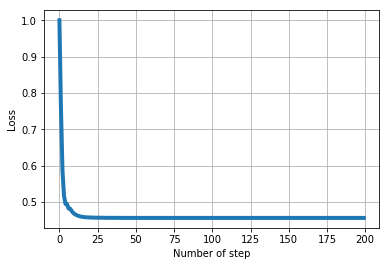

In [25]:
plt.plot(cost_history_SVRG, lw=4)
plt.grid()
#plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Number of step')
plt.show()

<a id='section4'></a>
SAGA

In [26]:
def SAGA(T, lam, eta):
    # initialisation
    theta = np.zeros(n_features)
    
    gi_hat = np.zeros([n_samples, n_features])
    g_bar = np.zeros(n_features)
    
    # historique de la fonction de perte
    cost_history = np.empty(shape=[T])
    
    for t in range(0,T): 
        cost_history[t] = f(theta, lam)
        
        # random sample an indice
        idx = np.random.randint(0, n_samples) 
        
        gi = partial_grad(theta, idx)
        
        # estimate gradient
        g_hat = gi - gi_hat[idx] + g_bar
        
        # update average gradient
        g_bar = g_bar + (1./n_samples) * (gi - gi_hat[idx])
        
        # update stored gradient
        gi_hat[idx] = gi
        
        # compute prox
        theta = theta - eta * g_hat - eta * lam * np.sign(theta)
            
               
    return theta, cost_history

In [27]:
%timeit SAGA(T=T,lam=lam,eta=eta)

10 loops, best of 3: 15.8 ms per loop


In [28]:
theta, cost_history_SAGA = SAGA(T=T, lam=lam, eta=eta)

In [29]:
print(theta)
print(w)

[-0.96692682 -1.28079646]
[-1.53292105 -1.71197016]


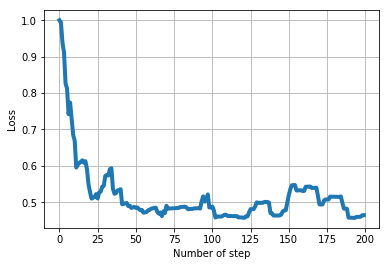

In [30]:
plt.plot(cost_history_SAGA, lw=4)
plt.grid()
#plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Number of step')
plt.show()

<a id='section5'></a>
Comparaison des algorithmes

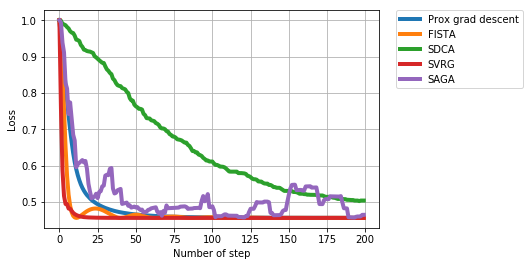

In [31]:
plt.plot(cost_history_PGD, lw=4, label='Prox grad descent')
plt.plot(cost_history_FISTA, lw=4, label='FISTA')
plt.plot(cost_history_SDCA, lw=4, label='SDCA')
plt.plot(cost_history_SVRG, lw=4, label='SVRG')
plt.plot(cost_history_SAGA, lw=4, label='SAGA')
plt.grid()
#plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Number of step')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()